# Simulation of a delta-hedged portfolio of European options

This code seeks to demonstrate how long and short positions in a European option is delta-hedged. The purpose of delta-hedging is to maintain a delta-neutral portfolio. This essentially means that gains or losses in the option position are offset by gains or losses in the underlying asset. As delta does not remain constant, the hedge must be adjusted or rebalanced periodically. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as si

plt.style.use('fivethirtyeight')

In [2]:
def GBM_sim(S, mu, T, sigma, N):
    '''
    Simulates a single path of Geometric Brownian Motion
    
    Args:
        S - initial path value
        mu - mean parameter
        T - time parameter
        sigma - volatility parameter
        N - number of steps in the path
    '''
    dt = T/N
    W = np.random.standard_normal(size=N-1)
    W = np.array([0] + list(np.cumsum(W)*np.sqrt(dt)))
    t = np.linspace(0, T, N)
    S = S*np.exp((mu - 0.5*sigma**2)*t + sigma*W)
    return S,t

Text(0.5, 1.0, 'Sample Path of GBM')

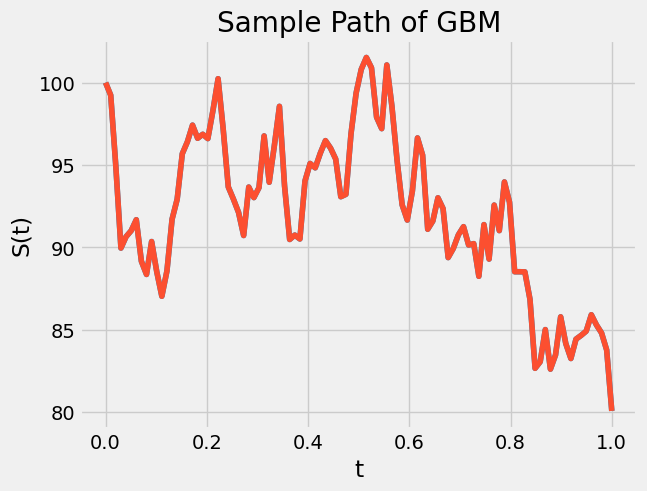

In [3]:
# Plotting sample path (for visual inspection)
path = GBM_sim(100,0.05,1.0,0.25,100);plt.plot(path[1], path[0])

plt.plot(path[1], path[0])
plt.xlabel('t')
plt.ylabel('S(t)')
plt.title('Sample Path of GBM')

In [4]:
def delta(S,K,T,r,q,sigma,CallPut):
    '''
    Returns the delta of the Black-Scholes option pricing formula
    Args:
        S - current price of the underlying asset
        K - strike price
        T - time to maturity
        r - risk-free rate
        q - dividend rate
        sigma - volatility parameter
        CallPut - 'Call' or 'Put' specification
    '''
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    if CallPut == 'Call':
        return si.norm.cdf(d1)*np.exp(-q*T)
    
    elif CallPut == 'Put':
        return si.norm.cdf(d1)*np.exp(-q*T) - 1.0


Text(0.5, 1.0, 'Variation of Delta w/ Stock Price for call option')

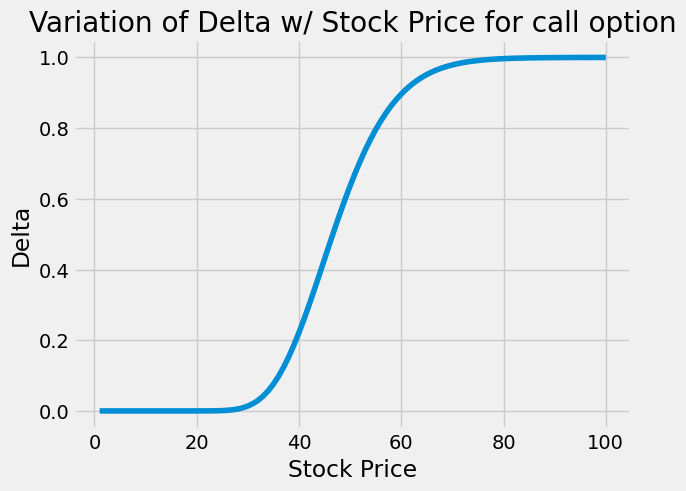

In [5]:
# Variation of delta with stock price for a long position in a call option on non-dividend 
# paying stock (K=50, T = 1 year, r=0.05, sigma=0.2)

S = np.linspace(1, 100, 100)
d = delta(S, K=50, T=1.0, r=0.05, q=0.0, sigma=0.2, CallPut='Call')

plt.plot(S, d)
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Variation of Delta w/ Stock Price for call option')

Text(0.5, 1.0, 'Variation of Delta w/ Stock Price for put option')

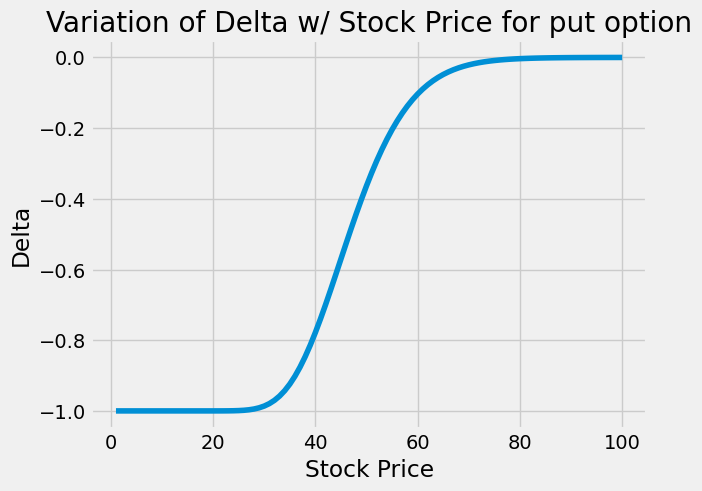

In [6]:
# Variation of delta with stock price for a long position in a put option on non-dividend 
# paying stock (K=50, T = 1 year, r=0.05, sigma=0.2)

S = np.linspace(1, 100, 100)
d = delta(S, K=50, T=1.0, r=0.05, q=0.0, sigma=0.2, CallPut='Put')

plt.plot(S, d)
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Variation of Delta w/ Stock Price for put option')

    Stock Price  Delta  Shares Purchased  Cost of Shares  Cumulative Cost  \
0    100.000000   0.63      6.274095e+04       6274100.0        6274100.0   
1     89.860358   0.45     -1.763718e+04      -1584900.0        4704900.0   
2     87.748801   0.40     -4.790427e+03       -420400.0        4296300.0   
3     88.159346   0.40     -2.259811e+02        -19900.0        4287100.0   
4     85.349681   0.34     -6.523065e+03       -556700.0        3741100.0   
5     92.780804   0.47      1.363796e+04       1265300.0        5015800.0   
6     94.204829   0.49      2.005555e+03        188900.0        5217300.0   
7     88.498488   0.36     -1.314195e+04      -1163000.0        4067300.0   
8     85.698566   0.29     -7.429883e+03       -636700.0        3440700.0   
9     79.727496   0.16     -1.309161e+04      -1043800.0        2405500.0   
10    80.947498   0.16      2.060100e+02         16700.0        2428200.0   
11    82.235645   0.16      2.423603e+02         19900.0        2454200.0   

/var/folders/c9/9wglc5bs7qbgt5h1pgfhnc4h0000gn/T/ipykernel_4610/1861954920.py:13: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


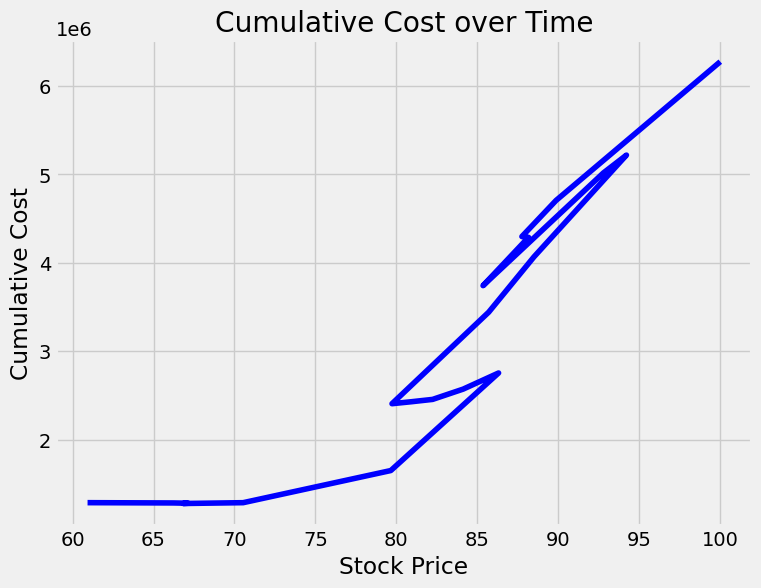

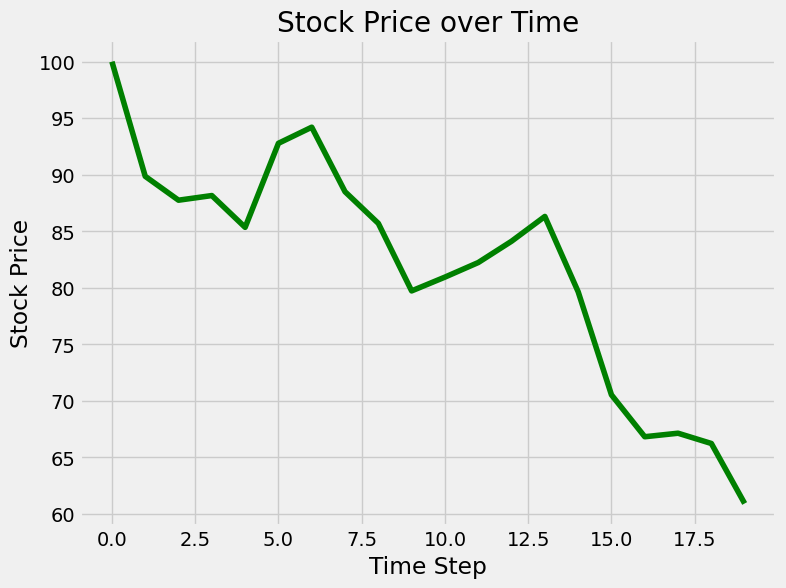

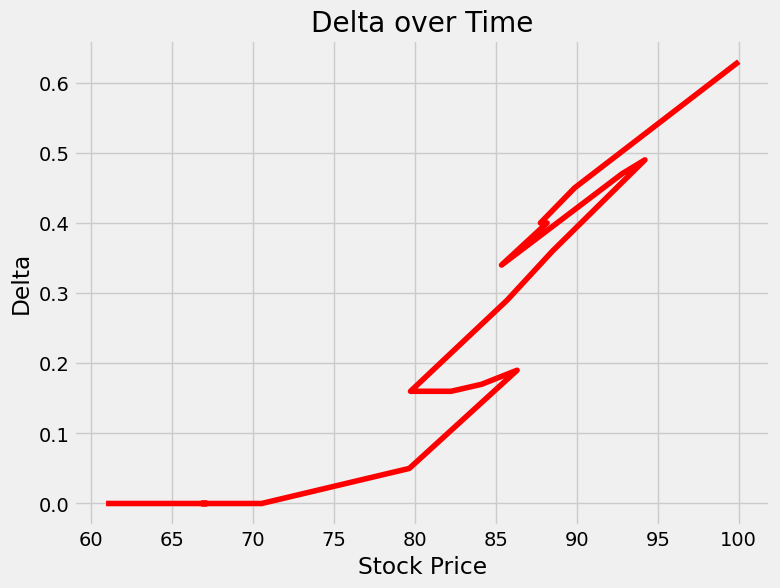

In [17]:
# Hedging Short Call with Long Stock:

# Consider short position in 100,000 European call options (S0 = 100, K = 100, T = 1 year, 
# r = 5%, sigma = 25%)

N = 100000 # short 100,000 call options

S0 = 100; K = 100; T = 1.0; r = 0.05; q = 0.0; sigma = 0.25 

N_steps = 20 # 20 timesteps --> rebalance 20 times throughout the life of the option

path = GBM_sim(S0, r- q, T, sigma ,N_steps)

St = path[0]; 
ttm = 1.0 - path[1]; 
dt = T/N_steps

d = delta(St, K, ttm, r, q, sigma, 'Call')

# Initial Position
n_shares = [d[0]*N]
cost_of_shares = [n_shares[0]*S0]

cumulative_cost = [n_shares[0]*S0]

interest_cost = [cumulative_cost[0]*r*dt]

# Rebalancing
for i in range(1, len(d)):
    diff = d[i] - d[i-1]
    n_shares.append(diff*N)
    cost_of_shares.append(n_shares[i]*St[i])
    cumulative_cost.append(cost_of_shares[i] + cumulative_cost[i-1] + interest_cost[i-1])
    interest_cost.append(cumulative_cost[i]*r*dt)
    
sim = pd.DataFrame({'Stock Price':St, 'Delta':np.round(d, 2),'Shares Purchased':np.array(n_shares),
                    'Cost of Shares':np.round(np.array(cost_of_shares),-2),
                    'Cumulative Cost':np.round(np.array(cumulative_cost),-2),
                    'Interest Cost':np.array(interest_cost)/1000})
print(sim)

# ... existing code ...

# Plot Cumulative Cost
plt.figure(figsize=(8, 6))
plt.plot(sim['Stock Price'], sim['Cumulative Cost'], label='Cumulative Cost', color='blue')
plt.xlabel('Stock Price')
plt.ylabel('Cumulative Cost')
plt.title('Cumulative Cost over Time')
plt.grid(True)
plt.show()

# Plot Stock Price
plt.figure(figsize=(8, 6))
plt.plot(sim['Stock Price'], label='Stock Price', color='green')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.title('Stock Price over Time')
plt.grid(True)
plt.show()

# Plot Delta
plt.figure(figsize=(8, 6))
plt.plot(sim['Stock Price'], sim['Delta'], label='Delta', color='red')
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta over Time')
plt.grid(True)
plt.show()

/var/folders/c9/9wglc5bs7qbgt5h1pgfhnc4h0000gn/T/ipykernel_4610/1861954920.py:13: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


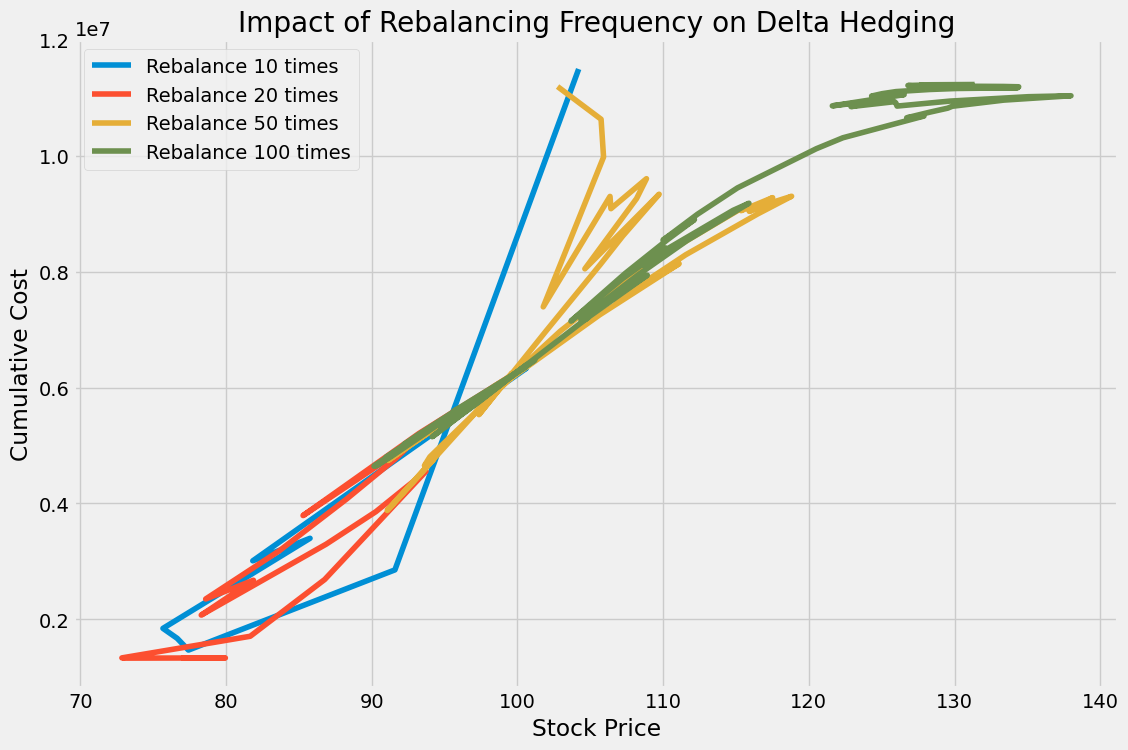

In [12]:
def delta_hedging_simulation(S0, K, T, r, q, sigma, N, rebalance_freq):
    """
    Simulate delta hedging with different rebalancing frequencies.
    
    Args:
        S0 - initial stock price
        K - strike price
        T - time to maturity
        r - risk-free rate
        q - dividend rate
        sigma - volatility
        N - number of options
        rebalance_freq - number of rebalancing steps
    """
    path = GBM_sim(S0, r - q, T, sigma, rebalance_freq)
    St = path[0]
    ttm = 1.0 - path[1]
    dt = T / rebalance_freq

    d = delta(St, K, ttm, r, q, sigma, 'Call')

    n_shares = [d[0] * N]
    cost_of_shares = [n_shares[0] * S0]
    cumulative_cost = [n_shares[0] * S0]
    interest_cost = [cumulative_cost[0] * r * dt]

    for i in range(1, len(d)):
        diff = d[i] - d[i - 1]
        n_shares.append(diff * N)
        cost_of_shares.append(n_shares[i] * St[i])
        cumulative_cost.append(cost_of_shares[i] + cumulative_cost[i - 1] + interest_cost[i - 1])
        interest_cost.append(cumulative_cost[i] * r * dt)

    sim = pd.DataFrame({
        'Stock Price': St,
        'Delta': np.round(d, 2),
        'Shares Purchased': np.array(n_shares),
        'Cost of Shares': np.round(np.array(cost_of_shares), -2),
        'Cumulative Cost': np.round(np.array(cumulative_cost), -2),
        'Interest Cost': np.array(interest_cost) / 1000
    })
    return sim

# Simulate with different rebalancing frequencies
frequencies = [10,20,50,100]
results = {}

for freq in frequencies:
    results[freq] = delta_hedging_simulation(S0=100, K=100, T=1.0, r=0.05, q=0.0, sigma=0.25, N=100000, rebalance_freq=freq)

# Plot results
plt.figure(figsize=(12, 8))
for freq, sim in results.items():
    plt.plot(sim['Stock Price'], sim['Cumulative Cost'], label=f'Rebalance {freq} times')

plt.xlabel('Stock Price')
plt.ylabel('Cumulative Cost')
plt.title('Impact of Rebalancing Frequency on Delta Hedging')
plt.legend()
plt.show()